## Speech Emotion Classification

## Problem Statement

Build a model to recognize emotion from speech using Ensemble learning 

## Dataset

**TESS Dataset**

The first dataset chosen for this mini-project is the [TESS](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF) (Toronto emotional speech set) dataset. It contains 2880 files.  A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses and the sets were recorded in seven different emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). Both actresses spoke English as their first language, were university educated, and had musical training. Audiometric testing indicated that both actresses had thresholds within the normal range.

**Ravdess Dataset**

The second dataset chosen for this mini-project is [Ravdess](https://zenodo.org/record/1188976#.YLczy4XivIU) (The Ryerson Audio-Visual Database of Emotional Speech and Song). This dataset contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

**File naming convention**

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

**Filename identifiers**

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: `03-01-06-01-02-01-12.wav`

    - Audio-only - 03
    - Speech - 01
    - Fearful - 06
    - Normal intensity - 01
    - Statement "dogs" - 02
    - 1st Repetition - 01
    - 12th Actor - 12 Female, as the actor ID number is even.

## Information

**Speech Emotion Recognition (SER)** is the task of recognizing the emotion from  speech, irrespective of the semantics. Humans can efficiently perform this task as a natural part of speech communication, however, the ability to conduct it automatically using programmable devices is a field of active research.

Studies of automatic emotion recognition systems aim to create efficient, real-time methods of detecting the emotions of mobile phone users, call center operators and customers, car drivers, pilots, and many other human-machine communication users. Adding emotions to machines forms an important aspect of making machines appear and act in a human-like manner

Lets gain familiarity with some of the audio based features that are commonly used for SER. 

**Mel scale** — The mel scale (derived from the word *melody*) is a perceptual scale of pitches judged by listeners to be equal in distance from one another. The reference point between this scale and normal frequency measurement is defined by assigning a perceptual pitch of 1000 mels to a 1000 Hz tone, 40 dB above the listener's threshold. Above about 500 Hz, increasingly large intervals are judged by listeners to produce equal pitch increments. Refer [here](https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8) for more detailed information.

**Pitch** — how high or low a sound is. It depends on frequency, higher pitch is high frequency

**Frequency** — speed of vibration of sound, measures wave cycles per second

**Chroma** — Representation for audio where spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma). Computed by summing the log frequency magnitude spectrum across octaves.

**Fourier Transforms** — used to convert from time domain to frequency domain. Time domain shows how signal changes over time. Frequency domain shows how much of the signal lies within each given frequency band over a range of frequencies

**Librosa**

[Librosa](https://librosa.org/doc/latest/index.html) is a Python package, built for speech and audio analytics. It provides modular functions that simplify working with audio data and help in achieving a wide range of applications such as identification of the personal characteristics of different individuals' voice samples, detecting emotions from audio samples etc. 

For further details on the Librosa package, refer [here](https://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf).


In [ ]:
#@title Download the datasets and install packages
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/M4_MP4_Ravdess_Tess.zip
!unzip -qq M4_MP4_Ravdess_Tess.zip
# Install packages
!pip -qq install librosa soundfile
!pip -qq install wavio
print("Datasets downloaded successfully!")

Datasets downloaded successfully!


### Import Neccesary Packages

In [ ]:
import librosa
import librosa.display
import soundfile
import os, glob, pickle, sys
import numpy as np
import pandas as pd
import IPython.display as ipd
from matplotlib import pyplot as plt
from datetime import datetime
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import warnings
warnings.filterwarnings('ignore')
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import VotingClassifier
import seaborn as sns

### Work-Flow

* Load the TESS audio data and extract features and labels

* Load the Ravdess audio data and extract features

* Combine both the audio dataset features

* Train and test the model with TESS + Ravdess Data

* Record the team audio samples and add them to TESS + Ravdess data

* Train and test the model with TESS + Ravdess + Team Recorded (combined) data

* Test each of the models with live audio sample recording.

### Load the Tess data and Ravdess data audio files (1 point)

Hint: `glob.glob`

In [ ]:
# YOUR CODE HERE
tess_file = glob.glob("Tess/*/*.wav")
print("TESS Dataset:", len(tess_file))
rav_file = glob.glob("ravdess/*/*.wav")
print("Ravdess Dataset:", len(rav_file))

TESS Dataset: 2679
Ravdess Dataset: 1168


#### Play the sample audio

In [ ]:
# Create a directory
os.mkdir("Records")

In [ ]:
# YOUR CODE HERE

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
    emt = input("Enter emotion(label) to save the recording: ")
    print("Start speaking!")
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d_%H-%M-%S")
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    b = b64decode(s.split(',')[1])
    with open('Records/audio_'+current_time+"_"+emt+'.wav','wb') as f:
      f.write(b)
    return 'Records/audio_'+current_time+"_"+emt+'.wav'

    # call the function to record a sample
record()

# change the path and listen to recorded audio sample
ipd.Audio("Tess/OAF_happy/OAF_back_happy.wav")

Enter emotion(label) to save the recording: happy
Start speaking!


<IPython.core.display.Javascript object>

### Data Exploration and Visualization (1 points)

In [ ]:
emotions_ = []
for file_name in tess_file:
    emotions_.append(file_name.split("/")[1])
set(emotions_)

{'OAF_Fear',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'OAF_surprised',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_sad',
 'YAF_surprised'}

#### Visualize the distribution of all the labels

In [ ]:
# YOUR CODE HERE
emotions_ = []
for file_name in rav_file:
    emotions_.append(file_name.split("/")[1])
set(emotions_)

{'Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24'}

#### Visualize sample audio signal using librosa

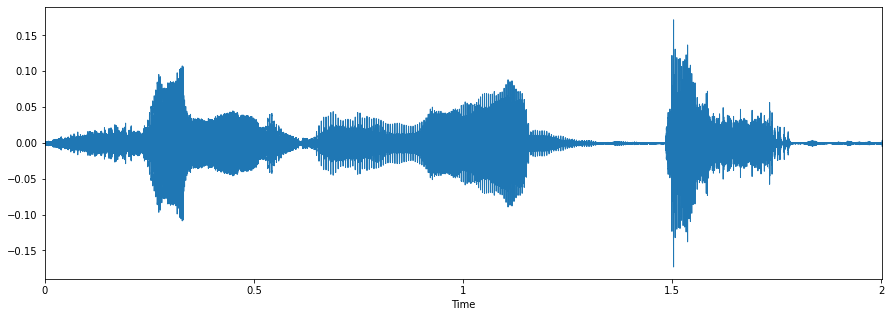

In [ ]:
sample_audio_path = '/content/Tess/OAF_happy/OAF_back_happy.wav'

# librosa is used for analyzing and extracting features of an audio signal
data, sampling_rate = librosa.load(sample_audio_path)
plt.figure(figsize=(15, 5))

# librosa.display.waveplot is used to plot waveform of amplitude vs time
librosa.display.waveplot(data, sr=sampling_rate)
plt.show()

In [ ]:
Tess = "/content/Tess"
Ravdess = ("/content/ravdess")

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + "/" +dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='surprised':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head(10)
#/content/Tess/OAF_Sad/OAF_back_sad.wav

,Emotions,Path
0,neutral,/content/TessOAF_neutral/OAF_cheek_neutral.wav
1,neutral,/content/TessOAF_neutral/OAF_page_neutral.wav
2,neutral,/content/TessOAF_neutral/OAF_bone_neutral.wav
3,neutral,/content/TessOAF_neutral/OAF_match_neutral.wav
4,neutral,/content/TessOAF_neutral/OAF_tool_neutral.wav
5,neutral,/content/TessOAF_neutral/OAF_white_neutral.wav
6,neutral,/content/TessOAF_neutral/OAF_keg_neutral.wav
7,neutral,/content/TessOAF_neutral/OAF_sail_neutral.wav
8,neutral,/content/TessOAF_neutral/OAF_tell_neutral.wav
9,neutral,/content/TessOAF_neutral/OAF_tip_neutral.wav


In [ ]:
Tess_df['Emotions'].unique()

array(['neutral', 'surprise', 'disgust', 'angry', 'sad', 'happy', 'fear'],
      dtype=object)

In [ ]:
Tess_df.Emotions.value_counts()

disgust     391
surprise    387
happy       383
angry       382
fear        379
sad         379
neutral     378
Name: Emotions, dtype: int64

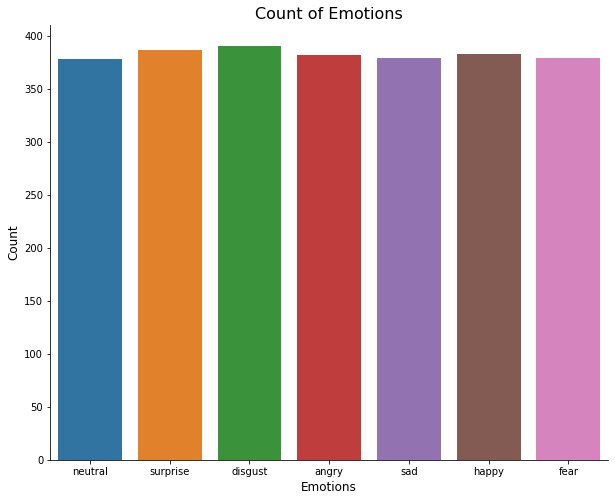

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('Count of Emotions', size=16)
sns.countplot(Tess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
gender = []
for dir in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + '/' + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split("-")
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        temp = int(part[4])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        file_path.append(Ravdess + dir + '/' + file)
       
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Rav_df = pd.concat([pd.DataFrame(gender),Ravdess_df],axis=1)
Rav_df.columns = ['Gender', 'Emotion', 'Path']
Rav_df.head(10)


,Gender,Emotion,Path
0,female,surprise,/content/ravdessActor_09/03-01-08-01-02-01-09_...
1,male,sad,/content/ravdessActor_09/03-01-04-02-01-01-09_...
2,male,surprise,/content/ravdessActor_09/03-01-08-02-01-01-09_...
3,female,fear,/content/ravdessActor_09/03-01-06-02-02-02-09_...
4,female,sad,/content/ravdessActor_09/03-01-04-02-02-02-09_...
5,male,sad,/content/ravdessActor_09/03-01-04-02-01-02-09_...
6,male,happy,/content/ravdessActor_09/03-01-03-01-01-02-09_...
7,male,happy,/content/ravdessActor_09/03-01-03-02-01-02-09_...
8,male,sad,/content/ravdessActor_09/03-01-04-01-01-01-09_...
9,male,angry,/content/ravdessActor_09/03-01-05-01-01-02-09_...


In [ ]:
Rav_df.Emotion.value_counts()

sad         183
fear        182
surprise    182
disgust     180
angry       179
happy       174
neutral      88
Name: Emotion, dtype: int64

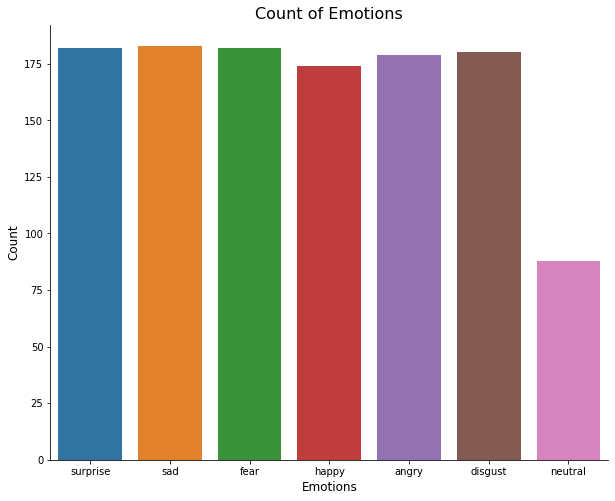

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('Count of Emotions', size=16)
sns.countplot(Rav_df.Emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_df = pd.concat([Ravdess_df, Tess_df], axis = 0)
data_df.to_csv("data_df.csv",index=False)
data_df.head()

,Emotions,Path
0,surprise,/content/ravdessActor_09/03-01-08-01-02-01-09_...
1,sad,/content/ravdessActor_09/03-01-04-02-01-01-09_...
2,surprise,/content/ravdessActor_09/03-01-08-02-01-01-09_...
3,fear,/content/ravdessActor_09/03-01-06-02-02-02-09_...
4,sad,/content/ravdessActor_09/03-01-04-02-02-02-09_...


In [ ]:
data_df['Emotions'].values

array(['surprise', 'sad', 'surprise', ..., 'disgust', 'disgust',
       'disgust'], dtype=object)

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3847 entries, 0 to 2678
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  3847 non-null   object
 1   Path      3847 non-null   object
dtypes: object(2)
memory usage: 90.2+ KB


In [ ]:
data_df.Emotions.value_counts()

disgust     571
surprise    569
sad         562
angry       561
fear        561
happy       557
neutral     466
Name: Emotions, dtype: int64

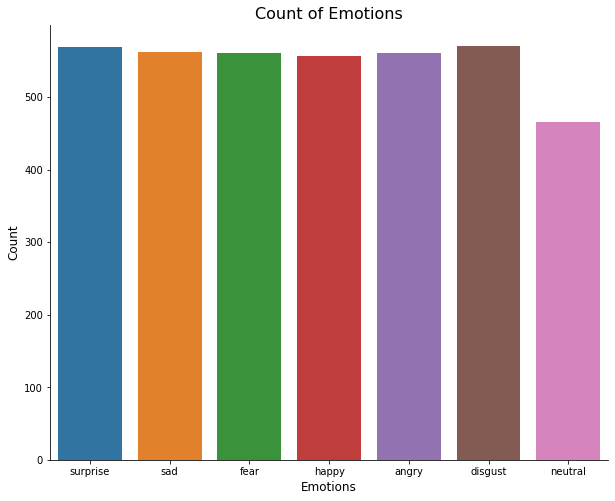

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('Count of Emotions', size=16)
sns.countplot(data_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

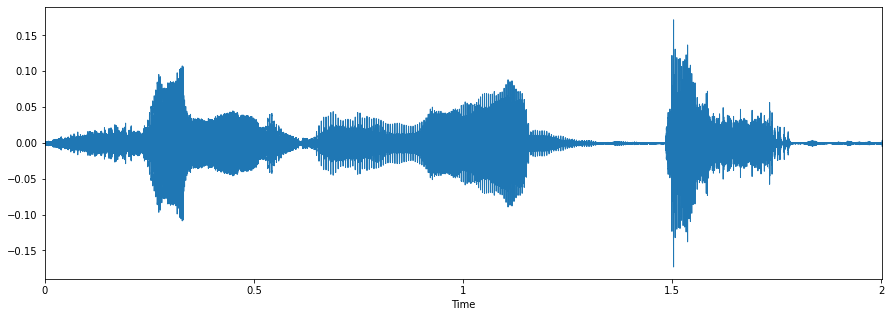

In [ ]:
# Tess OAF_happy happy track
fname = '/content/Tess/OAF_happy/OAF_back_happy.wav'

# librosa is used for analyzing and extracting features of an audio signal
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))

# librosa.display.waveplot is used to plot waveform of amplitude vs time
librosa.display.waveplot(data, sr=sampling_rate)
plt.show()

# Lets play the audio 
ipd.Audio(fname)

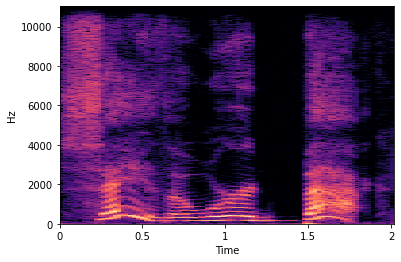

In [ ]:
stft_audio = librosa.stft(data)
Db_audio = librosa.amplitude_to_db(abs(stft_audio))
librosa.display.specshow(Db_audio, sr = sampling_rate, x_axis="time", y_axis="hz")

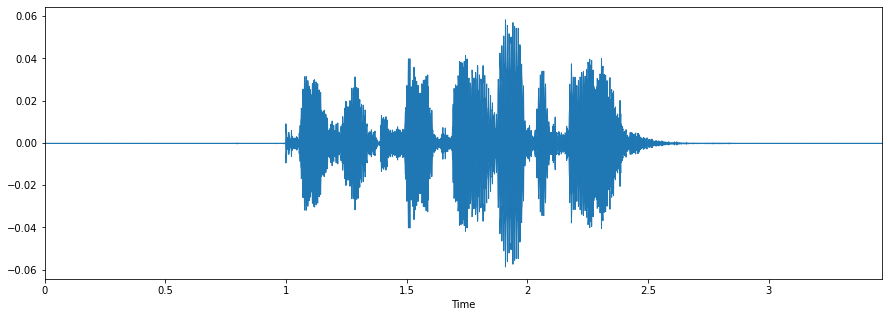

In [ ]:
# Ravdess Actor_1 happy track
fname = '/content/ravdess/Actor_01/03-01-03-01-01-01-01_happy.wav'

# librosa is used for analyzing and extracting features of an audio signal
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))

# librosa.display.waveplot is used to plot waveform of amplitude vs time
librosa.display.waveplot(data, sr=sampling_rate)
plt.show()

# Lets play the audio 
ipd.Audio(fname)

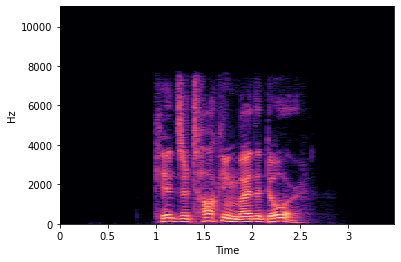

In [ ]:
stft_audio = librosa.stft(data)
Db_audio = librosa.amplitude_to_db(abs(stft_audio))
librosa.display.specshow(Db_audio, sr = sampling_rate, x_axis="time", y_axis="hz")
#Audio(data, rate = sampling_rate)

#### Create a dictionary or a function to encode the emotions

### Feature extraction (2 points)

Read one WAV file at a time using `Librosa`. An audio time series in the form of a 1-dimensional array for mono or 2-dimensional array for stereo, along with time sampling rate (which defines the length of the array), where the elements within each of the arrays represent the amplitude of the sound waves is returned by `librosa.load()` function. Refer to the supplementary notebook ('Audio feature extraction')

To know more about Librosa, explore the [link](https://librosa.org/doc/latest/feature.html)

In [ ]:
# YOUR CODE HERE
def extract_feature(file_name):
    # load audio
    X, sample_rate = librosa.load(file_name)
    # apply stft()
    stft=np.abs(librosa.stft(X))
    result=np.array([])
    # compute mfcc
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    # combine the features
    result=np.hstack((result, mfccs))
    # compute chroma features and combine
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, chroma))
    # compute melspectrogram and combine
    mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    result=np.hstack((result, mel))
    return result

In [ ]:
sample_feature = extract_feature(sample_audio_path)#,mfcc=True, chroma=True, mel=True)
sample_feature.shape

(180,)

 **Create a dictionary or a function to encode the emotions**

In [ ]:
emotions = {
    'neutral':1,
    'calm':2,
    'happy':3,
    'sad':4,
    'angry':5,
    'fear':6,
    'disgust':7,
    'surprised':8
    }

#### TESS data feature extraction

(13, 122)
Source - TESS; Emotion - Happy


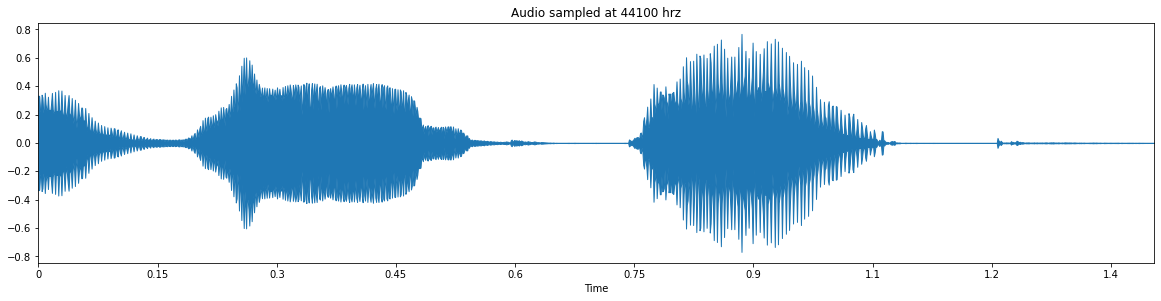

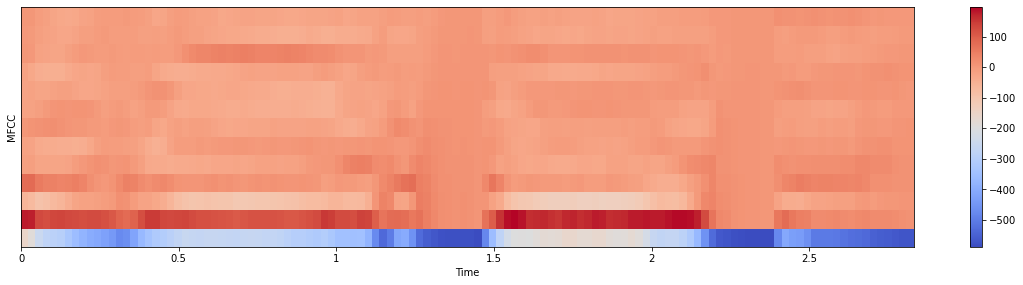

In [ ]:
# YOUR CODE HERE
# Source - TESS; Emotion - Happy
#path = "/content/Tess/OAF_happy/OAF_back_happy.wav"
path = "/content/Tess/YAF_happy/YAF_back_happy.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
print(mfcc.shape)
# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

print("Source - TESS; Emotion - Happy")
ipd.Audio(path)

In [ ]:
# Declare list to append features and labels
features, labels = [], []

for wv_file in tess_file:
  features.append(extract_feature(wv_file))
  # extracting label
  emt = wv_file.split('.')[0]
  emt = emt.split('_')[3]
  labels.append(emotions[emt])

In [ ]:
Tess_df1 = pd.DataFrame(features)
Tess_df1['labels'] = labels
len(Tess_df1)

2679

In [ ]:
Tess_df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,labels
0,-507.228210,50.122658,13.733974,23.957138,19.033381,4.728287,-2.761824,-3.795904,-13.974563,-4.013504,-12.080254,4.224219,-3.612871,4.575407,5.963174,6.139238,-1.682427,9.465481,-1.489272,-0.108966,5.028861,2.053297,-2.853290,3.202900,-7.531229,-2.277759,-2.473496,0.952105,-2.934798,1.793111,-5.961423,1.595920,-2.495287,8.998590,18.202202,28.148651,30.552025,25.475620,10.840503,4.131124,...,0.000659,0.000873,0.000645,0.000727,0.000603,0.000554,0.000414,0.000482,0.000419,0.000273,0.000387,0.000458,0.000342,0.000267,0.000339,0.000318,0.000535,0.000532,0.000543,0.000594,0.000404,0.000442,0.000372,0.000353,0.000487,0.000570,0.000359,0.000306,0.000275,0.000197,0.000166,0.000105,0.000105,0.000115,0.000093,0.000129,0.000129,0.000061,5.421691e-06,1
1,-516.943237,57.556709,20.335161,20.611963,16.190941,8.189936,-11.213996,-3.672147,-12.302428,-1.414308,-11.044280,2.999691,-7.205205,5.230474,7.376669,5.183539,-2.524958,8.098189,-1.602608,-1.088660,1.667347,2.828348,-2.879771,0.567354,-11.546830,-2.623518,-3.405650,1.340699,-4.400578,1.369966,-6.199730,-3.793111,-6.863116,5.415363,17.749556,25.938042,32.692589,34.405144,18.713263,6.512556,...,0.000249,0.000232,0.000153,0.000197,0.000366,0.000363,0.000260,0.000244,0.000213,0.000219,0.000120,0.000165,0.000167,0.000129,0.000111,0.000110,0.000128,0.000144,0.000169,0.000241,0.000273,0.000272,0.000160,0.000419,0.000620,0.000423,0.000146,0.000438,0.000340,0.000185,0.000167,0.000179,0.000070,0.000068,0.000038,0.000024,0.000034,0.000013,5.793165e-07,1
2,-553.718018,81.771507,30.141834,12.390797,6.782546,8.818099,1.818987,-1.655421,-12.378204,-2.243249,-8.928687,-3.043023,-1.046996,5.091726,7.372321,4.978412,-3.368759,3.201814,0.681903,-2.003792,0.697682,2.586403,-5.003079,2.000543,-3.563121,0.762486,-8.753381,-0.521214,-2.223695,1.131974,-5.243141,-1.473855,-8.343265,-3.403235,5.684871,16.779949,30.141552,37.456123,29.004114,23.887602,...,0.000235,0.000461,0.000284,0.000110,0.000070,0.000051,0.000050,0.000067,0.000070,0.000047,0.000019,0.000024,0.000054,0.000059,0.000040,0.000024,0.000028,0.000038,0.000052,0.000049,0.000059,0.000035,0.000048,0.000096,0.000064,0.000051,0.000050,0.000063,0.000042,0.000048,0.000042,0.000027,0.000027,0.000038,0.000044,0.000051,0.000047,0.000027,1.316129e-06,1
3,-499.930298,70.395470,6.632846,2.866935,10.670564,10.173056,-12.348202,-4.074434,-14.439302,1.241156,-5.105421,-0.420083,-4.782734,5.814880,6.958603,6.333807,-3.945243,8.053947,-0.428218,-1.385477,3.489509,0.630739,-4.213564,-0.930131,-12.419806,2.560390,-3.672411,1.767096,-5.761776,0.190444,-8.225341,1.673663,4.043566,22.012133,31.786352,34.778347,28.743813,14.870423,1.158593,1.198799,...,0.000235,0.000322,0.000295,0.000362,0.000178,0.000108,0.000148,0.000133,0.000087,0.000106,0.000174,0.000098,0.000103,0.000157,0.000105,0.000087,0.000095,0.000091,0.000121,0.000105,0.000130,0.000115,0.000091,0.000207,0.000349,0.000268,0.000161,0.000172,0.000221,0.000162,0.000118,0.000069,0.000048,0.000041,0.000039,0.000028,0.000023,0.000009,9.435540e-07,1
4,-525.094055,72.603279,30.020893,11.194328,3.277658,7.150697,-0.868844,-3.206078,-13.962986,-2.898391,-11.370793,1.584110,-8.545788,1.964937,6.169597,4.332197,-1.389762,8.472208,-3.527457,0.938489,2.066985,3.100309,-2.924060,2.275705,-8.854041,-1.004240,-7.448641,-1.983961,-2.334347,-0.253942,-5.504471,-2.083550,-5.478189,2.224984,12.924393,21.025747,33.328987,35.780689,22.859236,14.581769,...,0.000486,0.001085,0.000414,0.000374,0.000461,0.000459,0.000239,0.000240,0.000256,0.000151,0.000153,0.000204,0.000184,0.000140,0.000147,0.000105,0.000156,0.000209,0.000343,0.000290,0.000257,0.000188,0.000183,0.000254,0.000214,0.000182,0.000159,0.000228,0.000166,0.000134,0.000112,0.000084,0.000099,0.000053,0.000

#### Ravdess data feature extraction

(13, 216)
Source - RAVDESS; Gender - Male; Emotion - Happy


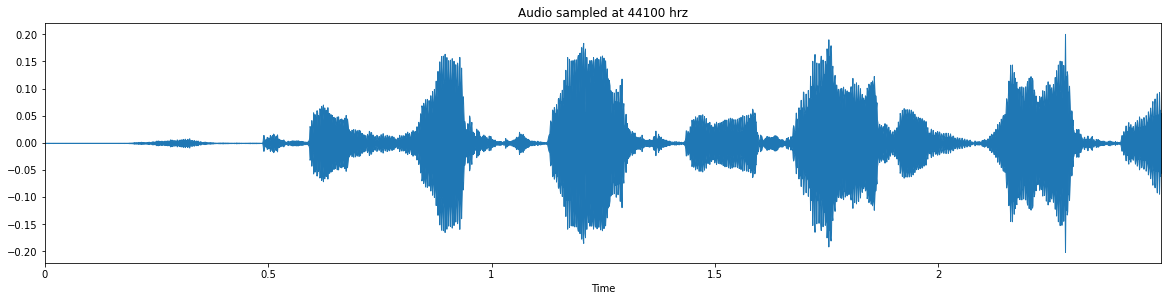

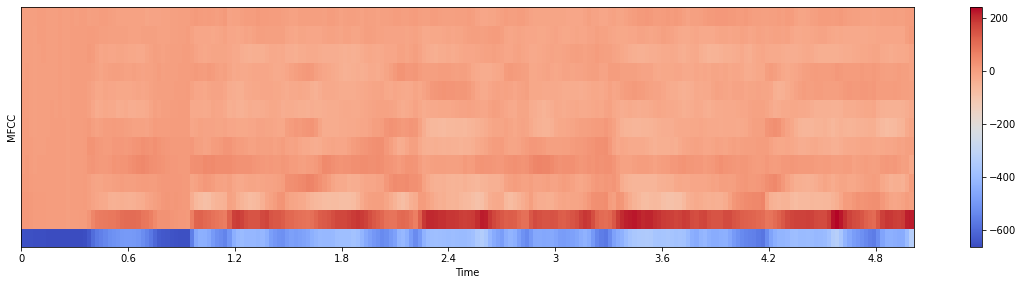

In [ ]:
# Source - RAVDESS; Gender - Male; Emotion - Happy
path = "/content/ravdess/Actor_09/03-01-03-02-01-02-09_happy.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
print(mfcc.shape)
# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

print("Source - RAVDESS; Gender - Male; Emotion - Happy")
ipd.Audio(path)

Source - RAVDESS; Gender - Female; Emotion - Happy


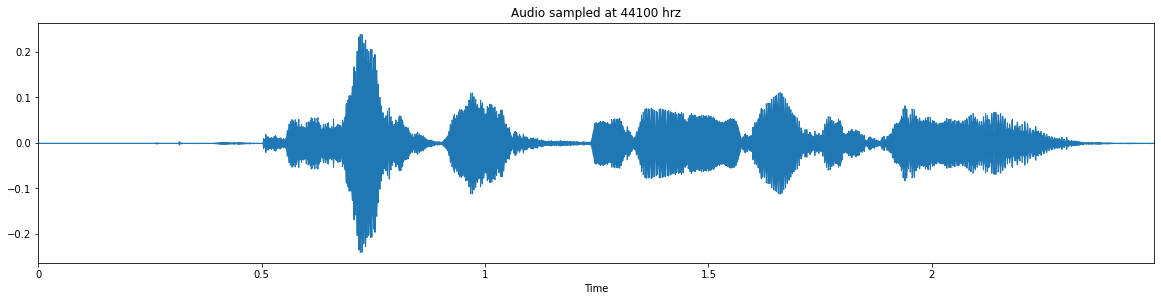

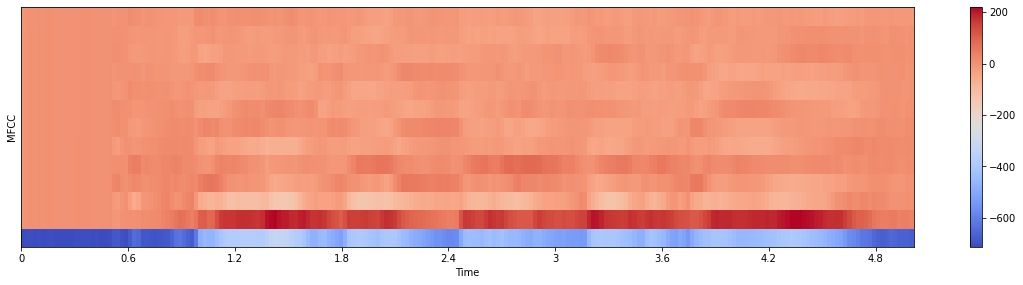

In [ ]:
# Source - RAVDESS; Gender - Female; Emotion - Happy
path = "/content/ravdess/Actor_08/03-01-03-02-02-01-08_happy.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
print("Source - RAVDESS; Gender - Female; Emotion - Happy")
ipd.Audio(path)


216
216


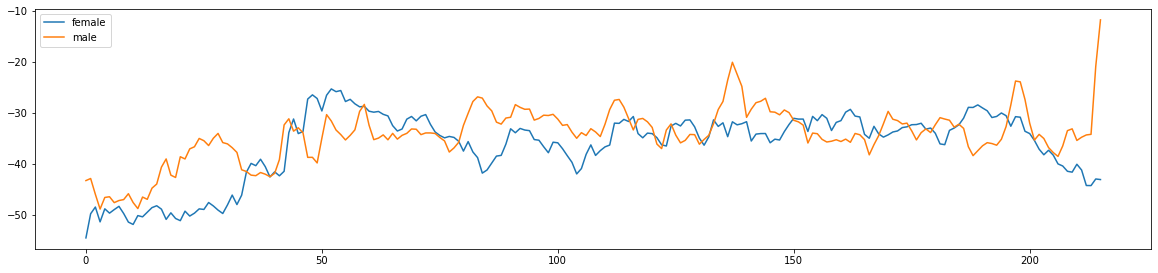

In [ ]:
# YOUR CODE HERE
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "/content/ravdess/Actor_08/03-01-03-02-02-01-08_happy.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "/content/ravdess/Actor_09/03-01-03-02-01-02-09_happy.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

**So for the sentence being uttered, there is a clear distint difference between male and female in that females tends to have a higher pitch.** 

In [ ]:
features_rav, labels_rav = [], []

for wv_file in rav_file:
  features_rav.append(extract_feature(wv_file))
  # extracting label
  emt = wv_file.split('/')[2]
  emt = emt.split('_')[1]
  emt = emt.split('.')[0]
  labels_rav.append(emotions[emt])

In [ ]:
Rav_df1 = pd.DataFrame(features_rav)
Rav_df1['labels'] = labels_rav
len(Rav_df1)

1168

#### Save the features

It is best advised to save the features in dataframe and maintain so that feature extraction step is not required to be performed every time.

* Make a DataFrame with features and labels

* Write dataframe into `.CSV` file and save it offline.

In [ ]:
# YOUR CODE HERE
data_df1 = pd.concat([Tess_df1,Rav_df1])
data_df1.to_csv('Final_df.csv')
data_df1.shape

(3847, 181)

#### Split the data into train and test

In [ ]:
# YOUR CODE HERE
X = data_df1.iloc[: ,:-1].values
y = data_df1['labels'].values
X.shape, y.shape

((3847, 180), (3847,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30, random_state= 123)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2692, 180), (2692,), (1155, 180), (1155,))

### Train the model with TESS + Ravdess data

* Apply different ML algorithms (eg. DecisionTree, RandomForest, etc.) and find the model with best performance

In [ ]:
# YOUR CODE HERE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
log_clf = LogisticRegression(random_state=42, solver="saga", penalty="l2", class_weight="balanced", C=0.8, max_iter=500)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)
print(log_clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8051948051948052


In [ ]:
from sklearn.model_selection import GridSearchCV
dec_clf = tree.DecisionTreeClassifier(random_state=10)
#hyperparamters to tune
parameters = dict(max_depth=[10,12,14,18,20], criterion=['gini', 'entropy'])
gs_clf = GridSearchCV(dec_clf, parameters)
gs_clf.fit(X_train, y_train)
print('Best Criterion:', gs_clf.best_estimator_.get_params()['criterion'])
print('Best max_depth:', gs_clf.best_estimator_.get_params()['max_depth'])

Best Criterion: entropy
Best max_depth: 14


In [ ]:
dt_clf = tree.DecisionTreeClassifier(max_depth = 14, criterion = 'entropy', random_state = 10)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
print(dt_clf.__class__.__name__, accuracy_score(y_test, y_pred))

DecisionTreeClassifier 0.7601731601731602


In [ ]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=550,
                       n_jobs=-1, oob_score=False, random_state=123,verbose=0, warm_start=False)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(rf.__class__.__name__, accuracy_score(y_test, y_pred))

RandomForestClassifier 0.8467532467532467


In [ ]:
rf_clf = RandomForestClassifier(n_estimators = 550,           # number of trees in the forest
                                #max_leaf_nodes=16,          # grow trees with max_leaf_nodes, selected by 
                                                            # relative reduction in impurity. 
                                                            # If None, then unlimited number of leaf nodes
                                random_state= 123, max_depth = 15, criterion = 'entropy', n_jobs = -1)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(rf_clf.__class__.__name__, accuracy_score(y_test, y_pred))

RandomForestClassifier 0.8467532467532467


In [ ]:
bag_clf = BaggingClassifier(base_estimator = dt_clf,     # base estimator to fit on random subsets of the dataset
                            n_estimators = 500,       # number of base estimators in the ensemble
                            max_samples = 0.4,        # number of samples to draw from X to train each base estimator. 
                                                    # If int, then draw max_samples samples.
                                                    # If float, then draw (max_samples * X.shape[0]) samples.
                            bootstrap=True,         # whether samples are drawn with replacement
                            random_state= 123,       # seed used by the random number generator to ensure reproducibility
                            n_jobs = -1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))

BaggingClassifier 0.8225108225108225


In [ ]:
ada_clf = AdaBoostClassifier(dt_clf, random_state = 10)
#hyperparamters to tune
parameters = dict(n_estimators = [300], learning_rate =[0.5, 0.6, 0.7])
gs_clf = GridSearchCV(ada_clf, parameters)
gs_clf.fit(X_train, y_train)
print('Best estimator:', gs_clf.best_estimator_.get_params()['n_estimators'])
print('Best learning_rate:', gs_clf.best_estimator_.get_params()['learning_rate'])

Best estimator: 300
Best learning_rate: 0.6


In [ ]:
ada_clf = AdaBoostClassifier(dt_clf, n_estimators = 500,
    algorithm = 'SAMME.R', learning_rate = 0.3, random_state = 123)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print(ada_clf.__class__.__name__, accuracy_score(y_test, y_pred))

AdaBoostClassifier 0.780952380952381


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
model = AdaBoostClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


Accuracy: 0.470 (0.047)


In [ ]:
from sklearn.ensemble import StackingClassifier
estimators = [('dt', tree.DecisionTreeClassifier(max_depth = 14, criterion = 'entropy', random_state = 10)),
              ('rd', RandomForestClassifier(n_estimators = 500, random_state = 123, n_jobs = -1, max_depth = 15, criterion = 'entropy')),
              ('ada', AdaBoostClassifier(dt_clf, n_estimators = 500,algorithm = 'SAMME.R', learning_rate = 0.3, random_state = 123))]
clf = StackingClassifier(estimators=estimators, final_estimator = LogisticRegression())
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

StackingClassifier 0.8510822510822511


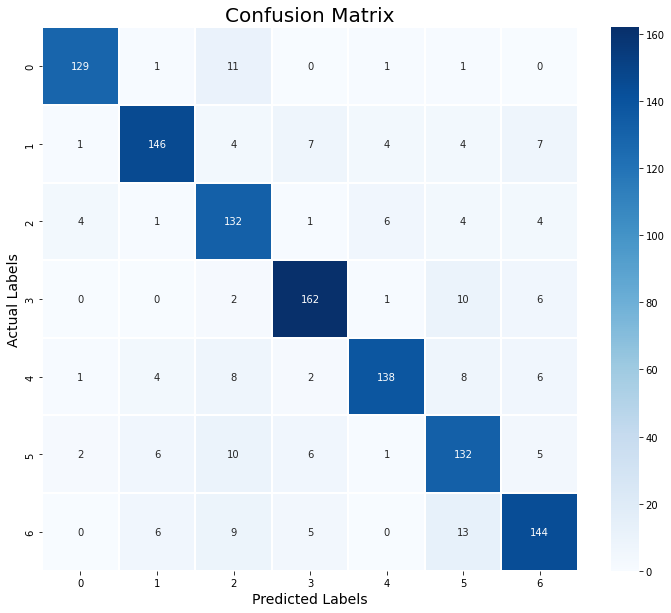

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print("The Classification report:")
print(classification_report(y_test, y_pred))

The Classification report:
              precision    recall  f1-score   support

           1       0.94      0.90      0.92       143
           3       0.89      0.84      0.87       173
           4       0.75      0.87      0.80       152
           5       0.89      0.90      0.89       181
           6       0.91      0.83      0.87       167
           7       0.77      0.81      0.79       162
           8       0.84      0.81      0.83       177

    accuracy                           0.85      1155
   macro avg       0.86      0.85      0.85      1155
weighted avg       0.86      0.85      0.85      1155



1. **We can see our model is more accurate in predicting surprise (8) and angry (5) emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc.**

2. **We overall achieved 85.62% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.**

#### Apply the voting classifier

In [ ]:
# YOUR CODE HERE
voting_clf = VotingClassifier(
       estimators = [('lr', log_clf), ('rf', rf_clf), ('df', dt_clf), ('bag', bag_clf), ('ada', ada_clf)],
       voting = 'hard'
)
voting_clf.fit(X_train, y_train)
y_pred1 = voting_clf.predict(X_test)
print(clf.__class__.__name__, accuracy_score(y_test, y_pred1))

StackingClassifier 0.8415584415584415


In [ ]:
voting_clf = VotingClassifier(
       estimators = [('lr', log_clf), ('rf', rf_clf), ('dt', dt_clf), ('bag', bag_clf), ('ada', ada_clf)],
       voting = 'soft'
)
voting_clf.fit(X_train, y_train)
y_pred2 = voting_clf.predict(X_test)
print(clf.__class__.__name__, accuracy_score(y_test, y_pred1))

StackingClassifier 0.8415584415584415


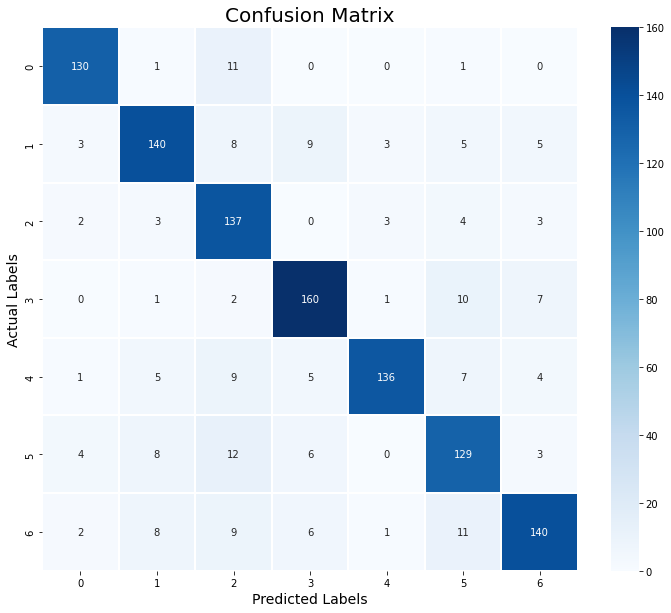

In [ ]:
cm = confusion_matrix(y_test, y_pred1)
plt.figure(figsize = (12, 10))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print("The Classification report:")
print(classification_report(y_test, y_pred1))

The Classification report:
              precision    recall  f1-score   support

           1       0.92      0.91      0.91       143
           3       0.84      0.81      0.83       173
           4       0.73      0.90      0.81       152
           5       0.86      0.88      0.87       181
           6       0.94      0.81      0.87       167
           7       0.77      0.80      0.78       162
           8       0.86      0.79      0.83       177

    accuracy                           0.84      1155
   macro avg       0.85      0.84      0.84      1155
weighted avg       0.85      0.84      0.84      1155



### Train the model with TESS + Ravdess + Team recorded data
* Record the audio samples (team data), extract features and combine with TESS + Ravdess data features
  - Record and gather all the team data samples with proper naming convention in separate folder

    **Hint:** Follow the supplementary notebook to record team data

  - Each team member must record 2 samples for each emotion (Use similar sentences as given in TESS data)

* Train the different ML algorithms and find the model with best performance

#### Load the team data

In [ ]:
# YOUR CODE HERE
def record(sec=3):
    emt = input("Enter emotion(label) to save the recording: ")
    print("Start speaking!")
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d_%H-%M-%S")
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    b = b64decode(s.split(',')[1])
    with open('Records/audio_'+current_time+"_"+emt+'.wav','wb') as f:
      f.write(b)
    return 'Records/audio_'+current_time+"_"+emt+'.wav'

In [ ]:
team_1 = record()
print(team_1)
ipd.Audio(team_1)

Enter emotion(label) to save the recording: angry
Start speaking!


<IPython.core.display.Javascript object>

Records/audio_2021-11-02_10-58-04_angry.wav


In [ ]:
team_2 = record()
print(team_2)
ipd.Audio(team_2)

Enter emotion(label) to save the recording: happy
Start speaking!


<IPython.core.display.Javascript object>

Records/audio_2021-11-02_10-58-21_happy.wav


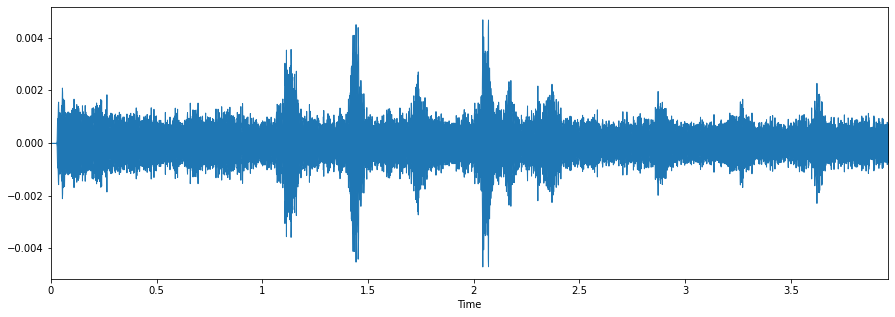

In [ ]:
# YOUR CODE HERE
# librosa is used for analyzing and extracting features of an audio signal
data, sampling_rate = librosa.load(team_1)
plt.figure(figsize=(15, 5))

# librosa.display.waveplot is used to plot waveform of amplitude vs time
librosa.display.waveplot(data, sr=sampling_rate)
plt.show()

In [ ]:
record_file = glob.glob("Records/*.wav")
len(record_file)

3

In [ ]:
emotions[emt]

4

#### Extracting features of team data and combine with TESS + Ravdess

In [ ]:
# YOUR CODE HERE
features_new, label_new = [], []

for wv_file in record_file:
  features_new.append(extract_feature(wv_file))
  emt = wv_file.split('/')[1]
  emt = emt.split('_')[3]
  emt = emt.split('.')[0]
  label_new.append(emotions[emt])
Recorded_df = pd.DataFrame(features_new)
Recorded_df['labels'] = label_new
len(Recorded_df)

3

#### Train the different ML algorithms

In [ ]:
# YOUR CODE HERE
data_df2 = pd.concat([data_df1,Recorded_df])
data_df2.to_csv('Final_df_new.csv')
data_df2.shape

(3850, 181)

In [ ]:
X_1 = data_df2.iloc[: ,:-1].values
y_1 = data_df2['labels'].values
X_1.shape, y_1.shape

((3850, 180), (3850,))

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size= 0.30, random_state= 123)
X_train_1.shape, y_train_1.shape, X_test_1.shape, y_test_1.shape

((2695, 180), (2695,), (1155, 180), (1155,))

In [ ]:
X_train_scaled = scaler.fit_transform(X_train_1)
X_test_scaled = scaler.transform(X_test)

In [ ]:
for clf in (log_clf, rf_clf, dt_clf, bag_clf, ada_clf):
    clf.fit(X_train_1, y_train_1)
    y_pred_1 = clf.predict(X_test_1)
    print(clf.__class__.__name__, accuracy_score(y_test_1, y_pred_1))

In [ ]:
voting_clf = VotingClassifier(
       estimators = [('lr', log_clf), ('rf', rf_clf), ('DT', dt_clf), ('bag', bag_clf), ('ada', ada_clf)],
       voting = 'hard'
)
voting_clf.fit(X_train_1, y_train_1)
ypred = voting_clf.predict(X_test_1)
print(clf.__class__.__name__, accuracy_score(y_test_1, ypred))

StackingClassifier 0.8398268398268398


In [ ]:
voting_clf = VotingClassifier(
       estimators = [('lr', log_clf), ('rf', rf_clf), ('DT', dt_clf), ('bag', bag_clf), ('svc', ada_clf)],
       voting = 'soft'
)
voting_clf.fit(X_train_1, y_train_1)
y_pred2 = voting_clf.predict(X_test_1)
print(clf.__class__.__name__, accuracy_score(y_test_1, y_pred2))

StackingClassifier 0.8207792207792208
